In [1]:
#!pip install -U sagemaker
# Make sure that we use SageMaker 2.x
!pip install sagemaker==2.31.1

In [2]:
%matplotlib inline

import os

import time
from time import gmtime, strftime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris
import boto3

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

## Step 1: Downloading the data

Fortunately, this dataset can be retrieved using sklearn and so this step is relatively straightforward.

In [16]:
boston = load_boston()

## Step 2: Preparing and splitting the data

Given that this is clean tabular data, we don't need to do any processing. However, we do need to split the rows in the dataset up into train, test and validation sets.

In [3]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# dividimos los dataset en 2/3 training y 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Luego dividimos el conjunto de entrenamiento en 2/3 de entrenamiento y 1/3 de conjuntos de validación.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## Paso 3: Subir los archivos de datos a S3

Cuando se construye un trabajo de entrenamiento usando SageMaker, se ejecuta un contenedor que realiza la operación de entrenamiento. Este contenedor tiene acceso a los datos almacenados en S3. Esto significa que necesitamos cargar los datos que queremos usar para entrenar a S3. Además, cuando realizamos un trabajo de transformación por lotes, SageMaker espera que los datos de entrada se almacenen en S3. Podemos usar la API de SageMaker para hacer esto y ocultar algunos de los detalles.

### Guarda los datos localmente

Primero necesitamos crear los archivos csv de prueba, entrenamiento y validación que luego cargaremos en S3.

In [4]:
# Nos aseguramos que exista el directorio local con la data 
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [5]:
# Usamos pandas para guardar nuestros datos de prueba, entrenamiento y validación en archivos csv. Tenga en cuenta que nos aseguramos de no incluir el encabezado
# información o un índice, ya que esto es requerido por los algoritmos integrados proporcionados por Amazon. 
# Además, para el tren y datos de validación, se asume que la primera entrada en cada fila es la variable objetivo.

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Creamos el bucket en S3 usando este código

#### no es necesario tener buckets creados previamente pero el IAM role que usas debe tener los permisos: AmazonS3FullAccess y AmazonSageMakerFullAccess

In [6]:
# Aquí hago la creación del bucket en S3 con el nombre que va en la variable prefix 
# y subo al bucket los datos que tengo en la instancia de notebook (que mueren cuando elimino la instancia)

prefix = 'boston-xgboost-HL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Paso 4: Entrena y construye el modelo XGBoost

Ahora que tenemos los datos de entrenamiento y validación cargados en S3, podemos construir un trabajo de entrenamiento para nuestro modelo XGBoost y construir el modelo en sí.

### Configurar el trabajo de entrenamiento

Primero, configuraremos y ejecutaremos un trabajo de entrenamiento para nuestro modelo. Para hacer esto, necesitamos especificar cierta información que SageMaker utilizará para configurar y ejecutar correctamente el cálculo. Para obtener documentación adicional sobre cómo construir un trabajo de entrenamiento, consulte la referencia de la [API CreateTrainingJob] (https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html).

### Creamos el container

In [7]:
# We will need to know the name of the container that we want to use for training. SageMaker provides
# a nice utility method to construct this for us.
container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, '1')
display(container)

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1'

### Seteamos los parámetros requeridos 

In [8]:
# We now specify the parameters we wish to use for our training job
training_params = {}

# We need to specify the permissions that this training job will have. For our purposes we can use
# the same permissions that our current SageMaker session has.
training_params['RoleArn'] = role

# Here we describe the algorithm we wish to use. The most important part is the container which
# contains the training code.
training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

# También necesitamos decir dónde nos gustaría almacenar los artefactos del modelo resultante.
training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

# También necesitamos establecer algunos parámetros para el trabajo de entrenamiento en sí. Es decir, 
# necesitamos describir qué tipo de instancia de cálculo que deseamos usar junto con una condición 
# de detención para manejar el caso de que haya algún tipo de error y el script de entrenamiento no termina.
training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

# A continuación, configuramos los hiperparámetros específicos del algoritmo. Es posible que desee cambiarlos para ver qué efecto
# hay en el modelo resultante.
training_params['HyperParameters'] = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

# Ahora necesitamos decirle a SageMaker de dónde se deben recuperar los datos.
training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

### Creamos el trabajo

In [9]:
# Primero tenemos que elegir un nombre de trabajo de formación. 
# Esto es útil si queremos recordar información sobre nuestro trabajo de formación en una fecha posterior. 
# Tenga en cuenta que SageMaker requiere un nombre de trabajo de formación y que el nombre debe
# ser único, lo que logramos agregando la marca de tiempo actual.
training_job_name = "boston-xgboost-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# Y ahora le pedimos a SageMaker que cree (y ejecute) el trabajo de entrenamiento
training_job = session.sagemaker_client.create_training_job(**training_params)
#El trabajo de entrenamiento ahora ha sido creado por SageMaker y se está ejecutando actualmente. 
# Dado que necesitamos el resultado del trabajo de entrenamiento, 
# es posible que deseemos esperar hasta que haya finalizado. 
#Podemos hacerlo pidiendo a SageMaker que genere los registros generados por el trabajo de entrenamiento 
#y continuar haciéndolo hasta que finalice el trabajo de entrenamiento.
session.logs_for_job(training_job_name, wait=True)

In [11]:
# Comenzamos pidiendo a SageMaker que nos describa los resultados del trabajo de entrenamiento
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [13]:
# Al igual que cuando creamos un trabajo de entrenamiento, el nombre del modelo debe ser único
model_name = training_job_name + "-model"

# También necesitamos decirle a SageMaker qué contenedor debe usarse para la inferencia y dónde debe
# recuperar los artefactos del modelo. En nuestro caso, el contenedor xgboost que usamos para entrenar
# también se puede utilizar para inferencias.
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

# Y por último construimos el modelo SageMaker
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Cannot create already existing model "arn:aws:sagemaker:us-east-1:547289857603:model/boston-xgboost-2021-04-23-21-37-01-model".

## Paso 5: Probar el modelo

Ahora que hemos ajustado nuestro modelo a los datos de entrenamiento, utilizando los datos de validación para evitar el sobreajuste, podemos probar nuestro modelo. Para hacer esto, haremos uso de la funcionalidad Batch Transform de SageMaker. En otras palabras, necesitamos configurar y ejecutar un trabajo de transformación por lotes, similar a la forma en que construimos el trabajo de entrenamiento anteriormente.

### Configurar el trabajo de transformación por lotes

Al igual que cuando estábamos entrenando nuestro modelo, primero necesitamos proporcionar cierta información en forma de una estructura de datos que describa el trabajo de transformación por lotes que deseamos ejecutar.

Solo usaremos algunas de las opciones disponibles aquí, pero para ver algunas de las opciones adicionales, consulte la documentación de SageMaker para [crear un trabajo de transformación por lotes] (https://docs.aws.amazon.com/sagemaker/latest/dg /API_CreateTransformJob.html).

In [17]:
# el nombre del trabajo debe ser único y usamos la misma lógica que utilizamos anteriormente
transform_job_name = 'boston-xgboost-batch-transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Ahora construimos la estructura de datos que describirá el trabajo de transformación por lotes.
transform_request = \
{
    "TransformJobName": transform_job_name,
    
    # Este es el nombre del modelo que creamos anteriormente.
    "ModelName": model_name,
    
     # Esto describe cuántas instancias de cómputo deben usarse a la vez. Si está haciendo 
     # un buen trabajo  de transformación por lotes, puede valer la pena ejecutar varias instancias a la vez.
    "MaxConcurrentTransforms": 1,
    
     # Esto indica el tamaño que debe tener cada solicitud individual enviada al modelo, como máximo.
     # Una de las cosas que SageMaker en segundo plano es dividir nuestros datos en trozos para que 
     # cada trozo permanezca debajo este límite de tamaño.
    "MaxPayloadInMB": 6,
    
    # A veces, es posible que deseemos enviar solo una muestra a nuestro punto final a la vez, sin embargo, 
    # en este caso, cada fragmento que enviamos deben contener múltiples muestras de nuestros datos de entrada.
    "BatchStrategy": "MultiRecord",
    
    # Este siguiente objeto describe dónde se deben almacenar los datos de salida. Algunas de las opciones más avanzadas que
     # que no cubrimos aquí también describe cómo SageMaker debería recopilar la salida de varios lotes..
    "TransformOutput": {
        "S3OutputPath": "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)
    },
    
     # Aquí describimos nuestros datos de entrada. Por supuesto, necesitamos decirle a SageMaker dónde en S3 se almacenan nuestros datos de entrada, en
     # Además, necesitamos detallar las características de nuestros datos de entrada. En particular, dado que SageMaker puede necesitar
     # dividir nuestros datos en trozos, necesita saber cómo aparecen las muestras individuales en nuestro archivo de datos. En nuestro
     # caso de que cada línea sea su propia muestra, por lo que establecemos el tipo de división en 'línea'. También necesitamos decirle a SageMaker qué
     # tipo de datos que se están enviando, en este caso csv, para que pueda serializar correctamente los datos.
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_location,
            }
        }
    },
    
    # Y, por último, le decimos a SageMaker qué tipo de instancia informática nos gustaría que utilizara.
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

### Ejecutar el trabajo de transformación por lotes

Ahora que hemos creado la estructura de datos de la solicitud, es hora de pedirle a SageMaker que configure y ejecute nuestro trabajo de transformación por lotes. Al igual que en los pasos anteriores, SageMaker realiza estas tareas en segundo plano, de modo que si queremos esperar a que termine el trabajo de transformación (y asegurarnos de que el trabajo está progresando), podemos pedirle a SageMaker que espere a que se complete el trabajo de transformación.

In [18]:
transform_response = session.sagemaker_client.create_transform_job(**transform_request)

In [19]:
transform_desc = session.wait_for_transform_job(transform_job_name)

...........................................................!


### Analiza los resultados

Ahora que el trabajo de transformación se ha completado, los resultados se almacenan en S3 como lo solicitamos. Como nos gustaría hacer un poco de análisis local, copiamos la salida resultante de S3 y la guardamos "localmente" en la
instancia del notebook, específicamente en el directorio data/boston que hemos creado para almacenar datos.
Si queremos descargarla en local de nuestro equipo, debemos hacerlo usando el comando download de jupyter

In [21]:
transform_output = "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)

In [23]:
!aws s3 cp --recursive $transform_output $data_dir

download: s3://sagemaker-us-east-1-547289857603/boston-xgboost-HL/batch-bransform/test.csv.out to ../data/boston/test.csv.out


Para ver qué tan bien funciona nuestro modelo, podemos crear un diagrama de dispersión simple entre los valores predichos y reales. Si el modelo fuera completamente preciso, el diagrama de dispersión resultante se vería como la línea $ x = y $. Como podemos ver, nuestro modelo parece haber funcionado bien, pero hay margen de mejora.

In [24]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0.5, 1.0, 'Median Price vs Predicted Price')

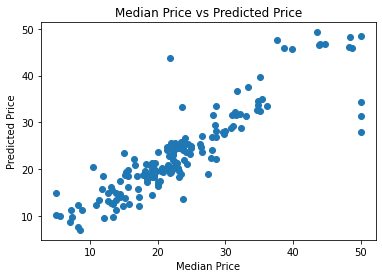

In [25]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## Opcional: Limpiar

La instancia de portátil predeterminada en SageMaker no tiene mucho espacio disponible en disco. A medida que continúe completando y ejecutando cuadernos, eventualmente llenará este espacio en el disco, lo que generará errores que pueden ser difíciles de diagnosticar. Una vez que haya terminado de usar un cuaderno, es una buena idea eliminar los archivos que creó durante el proceso. Por supuesto, puede hacerlo desde el terminal o desde el concentrador del portátil si lo desea. La celda a continuación contiene algunos comandos para limpiar los archivos creados desde dentro del cuaderno.

In [26]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir